In [1]:
# import packages
import h5py
import numpy as np
import torch
from mirtorch.linear import NuSense, Diff3dgram, Diag
from mirtorch.alg.cg import CG
import os
import sys
from recutl import mri_coil_compress
from vis3d import tim

In [ ]:
# set variables
gpu_idx = 2 # GPU index for CUDA (-1 = CPU)
fname_kdata = '/home/djfrey/data/acr_testing_20250407/lps.h5' # name of the GRE data file
fname_smaps = os.path.join(os.path.dirname(fname_kdata), 'smaps.h5') # name of the smaps file
ncoil_comp = 8 # number of virtual coils to compress to
cutoff = 0.8 # kspace cutoff for echo-in/out filtering
lam = 20 # regularization parameter for quadratic differencing penalty
niter = 30 # number of iterations for CG
ints2use = None # interleaf indices to use (None = all)
prjs2use = None # projection indices to use (None = all)
reps2use = None # repetition indices to use (None = all)
volwidth = None # number of projections per volume (None = use each rep as a volume)

In [3]:
# select device
if torch.cuda.is_available() & (gpu_idx >= 0):
    device0 = torch.device('cuda:2')
else:
    device0 = torch.device('cpu')
print(f'using device: {device0}')

using device: cuda:2


In [4]:
# load in the data
with h5py.File(fname_kdata, 'r') as h5_file:
    kdata = h5_file['kdata/real'][:] + 1j * h5_file['kdata/imag'][:] # kspace data
    k_in = h5_file['ktraj/spoke_in'][:] # kspace spoke-in trajectory (1/cm)
    k_out = h5_file['ktraj/spoke_out'][:] # kspace spoke-out trajectory (1/cm)
    fov = h5_file['seq_args/fov'][0][0] # field of view (cm)
    N = int(h5_file['seq_args/N'][0][0]) # 3D matrix size
    nseg = int(h5_file['seq_args/nseg'][0][0]) # number of points per segment
    nspokes = int(h5_file['seq_args/nspokes'][0][0]) # number of spokes
    nprj = int(h5_file['seq_args/nprj'][0][0]) # number of projections
    nint = int(h5_file['seq_args/nint'][0][0]) # number of interleaves
    nrep = int(h5_file['seq_args/nrep'][0][0]) # number of repetitions
    ncoil = int(h5_file['ncoil'][0][0]) # number of coils

# convert to tensors
kdata = torch.tensor(kdata).reshape(ncoil,nrep,nprj,nint,nseg*nspokes)
k_in = torch.tensor(k_in).reshape(3,nrep,nprj,nint,nseg*nspokes)
k_out = torch.tensor(k_out).reshape(3,nrep,nprj,nint,nseg*nspokes)

In [ ]:
# set default values for interleaves, projections, and repetitions to use
if ints2use is None:
    ints2use = nint
if prjs2use is None:
    prjs2use = nprj
if reps2use is None:
    reps2use = nrep
if volwidth is None:
    volwidth = prjs2use*ints2use

# get number of volumes
nvol = reps2use*prjs2use*ints2use // volwidth

# arrange data into volumes
kdata2 = kdata.clone()
kdata2 = kdata2[:,np.arange(reps2use),:,:,:]
kdata2 = kdata2[:,:,np.arange(prjs2use),:,:]
kdata2 = kdata2[:,:,:,np.arange(ints2use),:]
kdata2 = kdata2.reshape(ncoil,reps2use*prjs2use*ints2use,nseg*nspokes)
kdata2 = kdata2[:,:nvol*volwidth,:]
kdata2 = kdata2.reshape(ncoil,nvol,volwidth*nseg*nspokes)
kdata2 = kdata2.permute(1,0,2)

# arrange kspace trajectory into volumes
k_in2 = k_in.clone()
k_in2 = k_in2[:,np.arange(reps2use),:,:,:]
k_in2 = k_in2[:,:,np.arange(prjs2use),:,:]
k_in2 = k_in2[:,:,:,np.arange(ints2use),:]
k_in2 = k_in2.reshape(3,reps2use*prjs2use*ints2use,nseg*nspokes)
k_in2 = k_in2[:,:nvol*volwidth,:]
k_in2 = k_in2.reshape(3,nvol,volwidth*nseg*nspokes)
k_in2 = k_in2.permute(1,0,2)

k_out2 = k_out.clone()
k_out2 = k_out2[:,np.arange(reps2use),:,:,:]
k_out2 = k_out2[:,:,np.arange(prjs2use),:,:]
k_out2 = k_out2[:,:,:,np.arange(ints2use),:]
k_out2 = k_out2.reshape(3,reps2use*prjs2use*ints2use,nseg*nspokes)
k_out2 = k_out2[:,:nvol*volwidth,:]
k_out2 = k_out2.reshape(3,nvol,volwidth*nseg*nspokes)
k_out2 = k_out2.permute(1,0,2)

In [6]:
# load in the sensitivity maps
with h5py.File(fname_smaps, 'r') as h5_file:
    smaps = torch.tensor(h5_file['/real'][:] + 1j * h5_file['/imag'][:]).unsqueeze(0).to(kdata) # kspace data
smaps = smaps.permute(0,1,4,3,2) # 1 x C x X x Y x Z

In [7]:
# coil compress the data
kdata_comp,Vr = mri_coil_compress(kdata2, ncoil=ncoil_comp)

# coil compress the sensitivity maps
smaps_comp,_ = mri_coil_compress(smaps, Vr=Vr)

In [8]:
# convert trajectory to spatial frequencies
om_in = 2*torch.pi * fov/N * k_in2
om_out = 2*torch.pi * fov/N * k_out2

# create filter objects
Hvec_in = 1*(torch.norm(om_in,2,dim=1,keepdim=True) <= cutoff*torch.pi).repeat(1,ncoil_comp,1)
Hvec_out = 1*(torch.norm(om_out,2,dim=1,keepdim=True) <= cutoff*torch.pi).repeat(1,ncoil_comp,1)
H_in = Diag(Hvec_in.to(device0))
H_out = Diag(Hvec_out.to(device0))

# create nufft system operators with flat sensitivity
FS_in = NuSense(smaps_comp.to(device0), om_in.to(device0))
FS_out = NuSense(smaps_comp.to(device0), om_out.to(device0))

# set up system matrices and data
A = H_in*FS_in + H_out*FS_out
AHA = A.H*A

# add L2 roughness penalty
THT = Diff3dgram(FS_in.size_in)
AHA_tikh = AHA + lam*THT

# set up data
y = kdata_comp.to(device0)
AHy = A.H * y

# set up the CG solver
solv = CG(AHA_tikh, max_iter=niter)

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/djfrey/miniconda3/envs/umlps_recon_env/lib/python3.12/site-packages/torchkbnufft/_nufft/fft.py", line 114, in ifft_and_scale
    # ifft, crop, then multiply by scaling_coef conjugate
    return (
        crop_dims(
        ~~~~~~~~~ <--- HERE
            ifft_fn(image, grid_size.numel(), normalized=normalized), dims, im_size
        )
  File "/home/djfrey/miniconda3/envs/umlps_recon_env/lib/python3.12/site-packages/torchkbnufft/_nufft/fft.py", line 30, in crop_dims

    for dim, end in zip(dim_list, end_list):
        image = torch.index_select(image, dim, torch.arange(end, device=image.device))
                ~~~~~~~~~~~~~~~~~~ <--- HERE

    return torch.view_as_complex(image)
RuntimeError: CUDA out of memory. Tried to allocate 1.31 GiB. GPU 2 has a total capacity of 10.57 GiB of which 966.12 MiB is free. Including non-PyTorch memory, this process has 9.62 GiB memory in use. Of the allocated memory 8.17 GiB is allocated by PyTorch, and 1.28 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


In [ ]:
# solve with CG
x = solv.run(torch.zeros(nvol,1,N,N,N).to(kdata).to(device0), AHy)

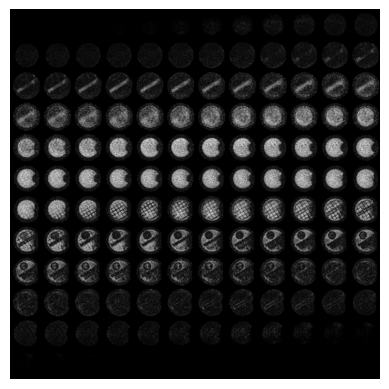

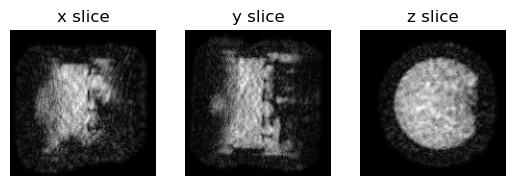

In [ ]:
# visualize the results
from vis3d import tim
tim(np.abs(x.squeeze().cpu().numpy()))
tim(np.abs(x.squeeze().cpu().numpy()),viewtype='mid3')